In [1]:
import os
import scipy.misc
from skimage.util.shape import view_as_windows
from sklearn.feature_extraction import image
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
import ra

%matplotlib notebook

In [2]:
#flags
height_ = 32
width_ = 40

flags = tf.app.flags
flags.DEFINE_integer("epoch", 15, "Epoch to train [20]") # changed from  15
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", height_, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", width_, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", height_, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", width_, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "train_img_slices", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "32_one_checkpoints/", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "32_one_samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [2]:
data = sorted(glob("./Patches32/*.npy"))
sample_files = data[0:64]
sample = [imread_new(d) for d in sample_files]

<IPython.core.display.Javascript object>


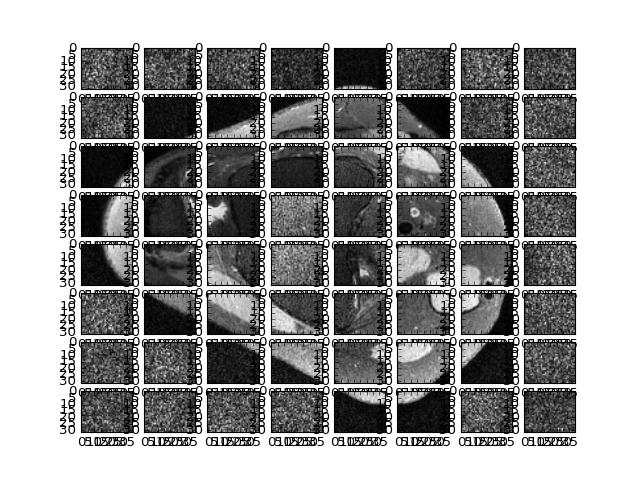

In [15]:
#plt.imshow(patch_together(sample[0:64], height=height_, width=width_), cmap ='gray')
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i], cmap ='gray')
    plt.show()

In [5]:
v = np.reshape(sample, (64, height_*width_))

In [6]:
num_iter = 500
all_patches = []
with tf.Session() as sess:

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for i in range(1):
        count = 0
        y_placeholder = tf.placeholder(tf.float32,[64,height_*width_])
        

        
        # -----------------------------------
        our_loss = tf.reduce_mean(tf.reduce_sum((tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1))
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): 
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: v})
            count += 1
            print(closs)
        all_patches.append(b)

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

<IPython.core.display.Javascript object>


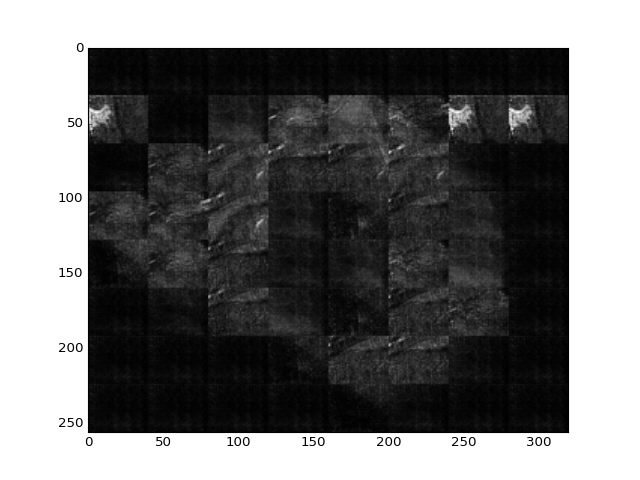

In [7]:
num = 0
np.shape(all_patches[0])
pics = np.reshape(all_patches, (64, height_, width_))
plt.imshow(patch_together(pics[num*64:(num+1)*64], height_, width_), cmap ='gray')
plt.show()